## imports

In [275]:
import investpy
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

## Load stock data

In [276]:
ticker_list = pd.read_excel(r"aktie_data.xlsx")
ticker_list.head()

,Aktie,Ticker,land,Typ
0,Atlas Copco,ATCOb,sweden,Aktie
1,Bio Gaia,BIOGb,sweden,Aktie
2,Camurus,CAMX,sweden,Aktie
3,Epiroc B,EPIRb,sweden,Aktie
4,Essity B,ESSITYb,sweden,Aktie


## Select stock / fund / commodity

In [277]:
row = 0
ticker = ticker_list.iloc[row][1]
country = ticker_list.iloc[row][2]
stock =ticker_list.iloc[row][0]
print(stock)

Atlas Copco


In [278]:
start_date = '01/01/2019'
today = str(dt.datetime.today().strftime("%d/%m/%Y"))

In [279]:
stock = investpy.get_stock_historical_data(stock=ticker,country=country,from_date=start_date,to_date=today)
stock = stock[["Close"]]
stock.head()

,Close
Date,
2019-01-02,193.9
2019-01-03,188.5
2019-01-04,200.1
2019-01-07,203.9
2019-01-08,207.6


In [283]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
stock["Close"] = scaler.fit_transform(stock["Close"].values.reshape(-1,1))
stock.head()

,Close
Date,
2019-01-02,-0.969705
2019-01-03,-1.000000
2019-01-04,-0.934923
2019-01-07,-0.913604
2019-01-08,-0.892847


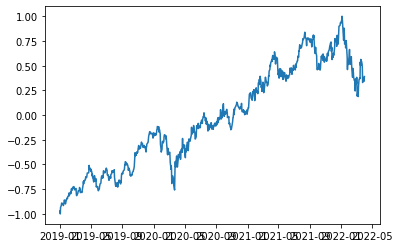

In [284]:
plt.plot(stock)

## Convert to tensor and create training data

In [285]:
#torch.tensor(stock.values)

In [286]:
def input_data(seq, ws):
    #seq = torch.tensor(df["Close"].values)
    #seq = torch.from_numpy(stock["Close"].values).float()
    out = [] #([0,1,2,3],[5])

    L = len(seq)

    for i in range(L-ws):

        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))   

    return out

## Convert df to tensor

In [287]:
stock = torch.from_numpy(stock["Close"].values).float()

In [288]:
length = len(stock)
train_length = int(length*0.8)
#test_length = length - train_length
train_set = stock[:train_length]

In [289]:
window_size = 40 
train_data = input_data(train_set, window_size)

In [291]:
optimizer.zero_grad()
model.hidden = (torch.zeros(1,1,model.hidden_size),
                torch.zeros(1,1,model.hidden_size))
y_pred = model(seq)

## Create LSTM

In [292]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, out_size=1):

        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size) # Create a layer of 50 neurons

        self.linear = nn.Linear(hidden_size, out_size)  # Condence back to 1 layer

        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)

        pred = self.linear(lstm_out.view(len(seq),-1))

        return pred[-1] # Only grab the last value 

        

In [293]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [297]:
epochs = 100
future = 40 

for i in range(epochs):

    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")
    preds = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])

        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            preds.append(model(seq).item())
    loss = criterion(torch.tensor(preds[-window_size:]),stock[-window_size:])
    print(f"Performance on test range: {loss}")

    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(stock)
    plt.plot(range(760, 800), preds[window_size:])
    plt.show()

AttributeError: 'LSTM' object has no attribute 'hidden_size'